In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

import requests

import astropy.units as u
from astropy import coordinates
from astropy.time import Time
from astropy.table import Table, Column
from astropy.coordinates import Distance, SkyCoord
from astropy.cosmology import WMAP7
from astroquery.mast import utils

import photutils

try:
    from alerce.core import Alerce
    client = Alerce()
except:
    from alerce.api import AlerceAPI  # old API
    client = AlerceAPI()
    print('WARNING: using old Alerce API')

import lightkurve as lk
import tess_stars2px
from tess_stars2px import tess_stars2px_function_entry
#import tess_cpm
#import tessreduce as tr

## TESS pointing + Alerce query

In [3]:
def date_to_mjd(date):
    """ Converts a TESS date to mjd.

    Parameters
    ----------
    date : str
        Date of TESS pointings.

    Returns
    -------
    Modified Julian Date (float).
    """
    
    month, day, year = date.split('/')
    isot = f'20{year}-{month}-{day}T00:30:00'
    mjd = np.round(Time(isot).mjd, 3)
    
    return mjd

def get_cam_coords(tess_cam_coords):
    """ Extract RA and Dec for a given TESS camera.

    Parameters
    ----------
    tess_cam_coords : str
        TESS camera coordnates

    Returns
    -------
    A list of RA and a list of Dec.
    """

    ra_list, dec_list = [], []
    for coords in tess_cam_coords:
        ra, dec, _ = coords.split(',')
        ra_list.append(ra), dec_list.append(dec)

    return ra_list, dec_list

def quick_ztf_target(oid):
    """ Retrieves a ZTF target's basic stats and coordinates with Alerce API.
    
    E.g., ZTF18acpfwmm

    Parameters
    ----------
    oid : str
        ZTF target id.

    Returns
    -------
    Dictionary with stats in pandas DataFrame and astropy coordinates of the target.
        
    """

    results = {"oid": oid}
    
    # query basic stats
    SN_stats = client.query_object(oid, format='pandas')
    results["stats"] = SN_stats

    # object coordinates
    results["coords"] = coordinates.SkyCoord(ra=float(SN_stats.meanra), dec=float(SN_stats.meandec), unit=(u.deg, u.deg), frame='icrs')

    return results

In [4]:
def get_sector_pointings(years=[1, 2, 3]):
    """ Retrieves TESS pointings for the sectors in the given years.

    Parameters
    ----------
    years : array-like
        Years of TESS pointings.

    Returns
    -------
    DataFrame with TESS pointings information.
    """
    
    base_url = 'https://raw.githubusercontent.com/villrv/tess_data/master/'
    columns = ['Sector', 'Dates', 'Spacecraft', 'Camera1', 'Camera2',	'Camera3', 'Camera4']
    
    # get data from the base_url
    pointings_df = pd.DataFrame(columns=columns)
    for i in years:
        url = os.path.join(base_url, f'year{i}.dat')
        year_df = pd.read_csv(url, names=columns, delim_whitespace=True, skiprows=1)
        pointings_df = pd.concat([pointings_df, year_df], ignore_index=True)
        
    # add starting and ending mjd for each sector
    start_mjd_col, end_mjd_col = [], []
    for pointing_dates in pointings_df.Dates:
        start_mjd, end_mjd = list(map(date_to_mjd, pointing_dates.split('-')))
        start_mjd_col.append(start_mjd), end_mjd_col.append(end_mjd)
        
    pointings_df['StartMJD'], pointings_df['EndMJD'] = start_mjd_col, end_mjd_col
    
    # extract RA and Dec for each camera
    for i in np.arange(1, 5):
        cam = f'Camera{i}'
        ra_list, dec_list = get_cam_coords(pointings_df[cam])
        
        pointings_df[f'RA{i}'], pointings_df[f'Dec{i}'] = ra_list, dec_list
        
    return pointings_df

In [5]:
pointings_df = get_sector_pointings()
pointings_df.head()

,Sector,Dates,Spacecraft,Camera1,Camera2,Camera3,Camera4,StartMJD,EndMJD,RA1,Dec1,RA2,Dec2,RA3,Dec3,RA4,Dec4
0,1,07/25/18-08/22/18,"352.68,-64.85,222.15","324.57,-33.17,289.92","338.58,-55.08,299.88","19.49,-71.98,157.19","90.00,-66.56,224.19",58324.021,58352.021,324.57,-33.17,338.58,-55.08,19.49,-71.98,90.00,-66.56
1,2,08/22/18-09/20/18,"16.56,-54.02,220.43","352.08,-23.06,294.47","5.70,-44.31,302.18","33.36,-62.19,144.76","90.00,-66.57,196.63",58352.021,58381.021,352.08,-23.06,5.70,-44.31,33.36,-62.19,90.00,-66.57
2,3,09/20/18-10/18/18,"36.31,-44.26,213.04","17.17,-12.22,293.55","28.46,-33.91,298.06","47.39,-53.85,131.45","90.00,-66.57,169.06",58381.021,58409.021,17.17,-12.22,28.46,-33.91,47.39,-53.85,90.00,-66.57
3,4,10/18/18-11/15/18,"55.01,-36.64,202.83","41.81,-2.76,288.16","49.88,-25.47,290.17","61.87,-47.52,117.45","90.00,-66.56,141.52",58409.021,58437.021,41.81,-2.76,49.88,-25.47,61.87,-47.52,90.00,-66.56
4,5,11/15/18-12/11/18,"73.54,-31.93,191.05","67.06,3.53,279.38","71.11,-20.13,279.98","76.70,-43.68,103.00","90.00,-66.56,114.14",58437.021,58463.021,67.06,3.53,71.11,-20.13,76.70,-43.68,90.00,-66.56


In [6]:
def single_query(ra, dec, start_mjd, end_mjd):
    """ Query for a single target using the Alerce API (https://alerce.readthedocs.io/en/latest/)

    Parameters
    ----------
    ra : float
        Target's RA.
    dec : float
        Target's Dec.
    start_mjd : float
        Lower limit of the time range to query.
    end_mjd : float
        Upper limit of the time range to query.

    Returns
    -------
    DataFrame with the target's query.
    """

    params = {
    #"total": total,
    "query_parameters": {
      "coordinates":{
        "ra": ra,
        "dec": dec,
        "sr": 61200 #This is roughly 12*sqrt(2) degrees
      },
      "filters": {
        "dates": {
          "firstmjd": {
            "min": start_mjd - 30,
            "max": end_mjd
          }
        }
      }
    }
    }
    api = AlerceAPI()
    resp_df = api.query(params, format="pandas")
    
    return resp_df

def get_queries(pointings_df):
    """ Multiple queries for the different sectors and cameras.

    Parameters
    ----------
    pointings_df : DataFrame
        DataFrame with TESS pointings information (obtained with `get_sector_pointings`).

    Returns
    -------
    A list of queries for each Camera in a dictionary with the Cameras as key values.
    """

    resp_dict = {}
    for i in np.arange(1, 5):
        ra_list, dec_list = pointings_df[f'RA{i}'], pointings_df[f'Dec{i}']
        start_mjd_list, end_mjd_list = pointings_df['StartMJD'], pointings_df['EndMJD']

        resp_list = list(map(single_query, ra_list, dec_list, start_mjd_list, end_mjd_list))
        resp_dict[f'Camera{i}'] = resp_list

    return resp_dict

In [7]:
# this can take a very long time
# year = 2
# resp_dict = get_queries(pointings_df[pointings_df.Year==year])  

___
# Plot ZTF targets

In [116]:
import pandas as pd

In [120]:
test = get_ztf_target('ZTF20aapycrh')

In [126]:
test.keys()

dict_keys(['oid', 'stats', 'coords', 'sectors'])

In [124]:
pd.DataFrame(test.T)

AttributeError: 'dict' object has no attribute 'T'

In [15]:
client.query_object('ZTF20aapycrh', format='pandas')

,oid,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,g_r_mean,g_r_mean_corr,firstmjd,lastmjd,deltajd,meanra,meandec,sigmara,sigmadec,step_id_corr
0,ZTF20aapycrh,151,869,58900.267454,59020.239676,True,False,53,-0.001371,0.035281,0.125338,0.171159,58900.326366,59020.239676,119.91331,164.245241,43.076841,0.000044,0.000026,corr_bulk_0.0.1


In [133]:
SN_det = client.query_detections(name, format='pandas')
SN_nondet = client.query_non_detections(name, format='pandas')

,mjd,diffmaglim,fid
0,58871.426146,20.5179,1
1,58871.430278,20.6698,1
2,58871.492303,20.1504,2
3,58871.495521,20.2313,2
4,58873.326875,20.4994,2
...,...,...,...
66,59009.236157,19.9500,1
67,59013.228160,20.2038,1
68,59017.220220,20.4173,1
69,59017.240880,20.2801,2


In [163]:
sd = SN_det[['mjd','magpsf','sigmapsf','fid']]
sd['maglim'] = np.nan#SN_det['diffmaglim']
sn = SN_nondet[['mjd','diffmaglim','fid']]
sn = sn.rename(columns={'diffmaglim':'maglim'})
sn['magpsf'] = np.nan
sn['sigmapsf'] = np.nan
sd = sd.append(sn)
sd = sd.sort_values('mjd',ignore_index=True)
sd.fid.iloc[sd.fid.values==1] = 'g'
sd.fid.iloc[sd.fid.values==2] = 'r'

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/rridden/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [164]:
sd

,mjd,magpsf,sigmapsf,fid,maglim
0,58871.426146,NaN,NaN,g,20.5179
1,58871.430278,NaN,NaN,g,20.6698
2,58871.492303,NaN,NaN,r,20.1504
3,58871.495521,NaN,NaN,r,20.2313
4,58873.326875,NaN,NaN,r,20.4994
...,...,...,...,...,...
119,59013.228160,NaN,NaN,g,20.2038
120,59017.220220,NaN,NaN,g,20.4173
121,59017.240880,NaN,NaN,r,20.2801
122,59020.203426,NaN,NaN,g,20.5609


<IPython.core.display.Javascript object>


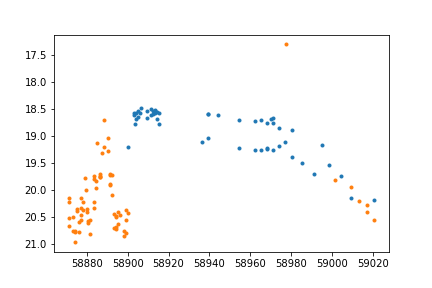

In [158]:
plt.figure()
plt.plot(sd.mjd,sd.magpsf,'.')
plt.plot(sd.mjd,sd.maglim,'.')
plt.gca().invert_yaxis()

In [159]:
sd[sd.fid.values==1] = 'g'
sd[sd.fid.values==2] = 'r'

In [7]:
def get_ztf_target(oid):
    """ Retrieves a ZTF target data with Alerce API.
    
    E.g., ZTF18acpfwmm

    Parameters
    ----------
    oid : str
        ZTF target id.

    Returns
    -------
    Dictionary with the target's data.
        
    """

    results = {"oid": oid}
    
    # query basic stats
    try:
        SN_stats = client.query_object(oid, format='pandas')
    except:  # old Alerce API
        query_dict = {"query_parameters":{"filters":{"oid": oid}}}
        SN_stats = client.query(query_dict, format='pandas')
    results["stats"] = SN_stats
    
    # object coordinates
    coords = coordinates.SkyCoord(ra=float(SN_stats.meanra), dec=float(SN_stats.meandec), unit=(u.deg, u.deg), frame='icrs')
    results["coords"] = coords

    # find TESS sectors
    pointings_df = get_sector_pointings()

    firstmjd = results["stats"].firstmjd.values[0]
    lastmjd = results["stats"].lastmjd.values[0]

    date_maks = (pointings_df.StartMJD.values <= firstmjd) & (pointings_df.EndMJD.values >= firstmjd)
    first_sector = pointings_df[date_maks].Sector.values[0]
    date_maks = (pointings_df.StartMJD.values <= lastmjd) & (pointings_df.EndMJD.values >= lastmjd)
    last_sector = pointings_df[date_maks].Sector.values[0]

    results["sectors"] = np.arange(first_sector, last_sector+1)
        
    # return data
    return results

def plot_ztf_target(oid):
    """ Given a ZTF target id, this will plot a ZTF light curve from Alerce.
    
    Parameters
    ----------
    oid : str
        ZTF target id.
        
    """
        
    # query detections
    try:
        SN_det = client.query_detections(oid, format='pandas')
    except:  # old Alerce API
        SN_det = client.get_detections(oid, format='pandas')
    SN_det = SN_det.sort_values("mjd")
        
    # query non detections
    try:
        SN_nondet = client.query_non_detections(oid, format='pandas')
    except:  # old Alerce API
        SN_nondet = client.get_non_detections(oid, format='pandas')
        if SN_nondet.index.name == 'mjd':
            SN_nondet.reset_index(level=0, inplace=True)
            
    SN_nondet = SN_nondet.sort_values("mjd")

    # plotting properties
    labels = {1: 'g', 2: 'r'}
    markers = {1: '--o', 2: '--s'}
    sizes = {1: 60, 2: 60}
    colors = {1: '#56E03A', 2: '#D42F4B'}  # color blind friendly green and red 
    
    fig, ax = plt.subplots(figsize=(12, 7))
      
    # loop the passbands
    for fid in [1, 2]:
        
        # plot detections if available
        mask = SN_det.fid == fid
        if np.sum(mask) > 0:
            # note that the detections index is candid and that we are plotting the psf corrected magnitudes
            ax.errorbar(SN_det[mask].mjd, SN_det[mask].magpsf, 
                yerr = SN_det[mask].sigmapsf, c=colors[fid], label=labels[fid], fmt=markers[fid])
        
        # plot non detections if available
        mask = (SN_nondet.fid == fid) & (SN_nondet.diffmaglim > -900)
        if np.sum(mask) > 0:     
            # non detections index is mjd
            ax.scatter(SN_nondet[mask].mjd, SN_nondet[mask].diffmaglim, c=colors[fid], alpha = 0.6,
                marker='v', s=sizes[fid])
            
    ax.set_xlabel('MJD', fontsize=14)
    ax.set_ylabel('Apparent Mag.', fontsize=14)
    ax.set_title(oid, fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.gca().invert_yaxis()
    ax.legend(frameon=False,fontsize=16)
    fig.patch.set_facecolor('xkcd:white')
    plt.show()

<IPython.core.display.Javascript object>


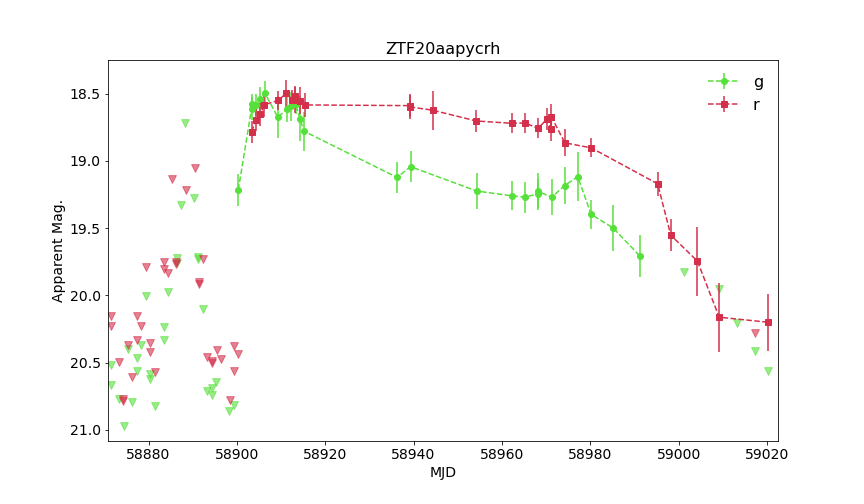

In [10]:
plot_ztf_target("ZTF20aapycrh")

___
## Find SNe in TESS

In [10]:
def tess_observed(sector, time, pointings_df):
    """ Check if a SN should be visible in a given TESS sector.

    Parameters
    ----------
    sector : int
        TESS sector number.
    time : float
        Time at which to check if the SN was observed by TESS.
    pointings_df : DataFrame
        DataFrame with TESS pointings information (obtained with `get_sector_pointings`).

    Returns
    -------
    Bool. True if TESS observed the SN in the given time window, False otherwise.
    """
    
    sector_df = pointings_df[pointings_df.Sector==sector]
    start_mjd, end_mjd = sector_df.StartMJD.values[0], sector_df.EndMJD.values[0]

    if (time > start_mjd - 30) and (time < end_mjd + 100):
        print(f'This transient is in sector {sector}')
        return True
    
    print(f'This transient is NOT in sector {sector}')
    return False

def get_osc_coords(object_name):
    """ Get object coordinates from the Open Supernova Catalog (OSC).

    Parameters
    ----------
    object_name : str
        Object's name to search on OSC.

    Returns
    -------
    Astropy SkyCoord with the object's coordinates and `maxdate` value (in MJD) 
    of the object from OSC.
    """
    
    # get object metadata
    osc_link = f'https://astrocats.space/api/{object_name}/ra+dec+maxdate'
    osc_request = requests.get(osc_link).json()
    osc_data    = osc_request[object_name]
    
    # get coordinates
    ra = osc_data['ra'][0]['value']
    dec = osc_data['dec'][0]['value']
    maxdate = osc_data['maxdate'][0]['value']
    maxmjd = Time(maxdate.replace('/','-')+'T00:00:00', format='isot', scale='utc').mjd
    
    coords = coordinates.SkyCoord(ra, dec, unit=(u.hourangle, u.deg))
    return coords, maxmjd

/home/tomas/anaconda3/lib/python3.6/site-packages/lightkurve/search.py:313: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)


<AxesSubplot:title={'center':'Target ID: 85.30749999999999 -13.224261111111112, Cadence: 0'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

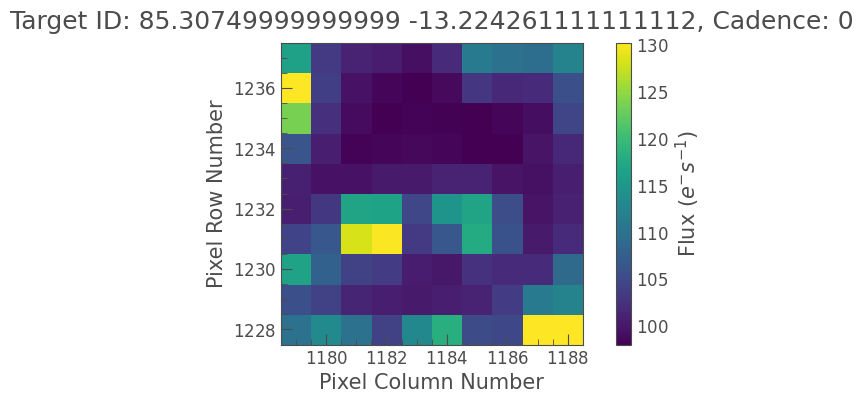

In [11]:
object_name = 'ZTF18adaifep'
obj_coords, maxmjd = get_osc_coords(object_name)
ra, dec = obj_coords.ra.deg, obj_coords.dec.deg

# search object in TESS
coords_str = f'{ra} {dec}'
search_result = lk.search_tesscut(coords_str)
tpf = search_result.download(cutout_size=10)
tpf.plot()

In [12]:
# check good sectors
outID, outEclipLong, outEclipLat, outSecs, outCam, outCcd, outColPix, \
outRowPix, scinfo = tess_stars2px_function_entry(666, ra, dec)

good_secs = []
for outSec in outSecs:
    in_tess = tess_observed(outSec, maxmjd, pointings_df)
    if in_tess:
        good_secs.append(outSec)

This transient is in sector 6
This transient is NOT in sector 32


___
## CPM

In [13]:
from astroquery.mast import utils
import tess_cpm

In [14]:
# Helper functions for doing CPM
class CPM():
    def __init__(self, ra, dec, sector, ffi_size):
        self.ra = ra
        self.dec = dec
        self.sector = sector 
        self.ffi_size = ffi_size
    
    def check_before_download(self, coordinates=None, size=5, sector=None, path=".", inflate=True, objectname=None, force_download=False):
        coords = utils.parse_input_location(coordinates, objectname)
        ra = f"{coords.ra.value:.6f}"
        matched = [m for m in os.listdir(path) if ra in m]
        if (len(matched) != 0) and (force_download == False):
            print(f"Found the following FITS files in the \"{path}/\" directory with matching RA values.")
            print(matched)
            print("If you still want to download the file, set the \'force_download\' keyword to True.")
            return matched
        else:
            path_to_FFIs = Tesscut.download_cutouts(coordinates=coordinates, size=size, sector=sector, path=path, inflate=inflate, objectname=objectname)
            print(path_to_FFIs)
            return path_to_FFIs 
        
    def FFI_source(self):
        # Check path
        PATH = self.check_before_download(coordinates=SkyCoord(self.ra, self.dec, unit="deg"), sector=self.sector, size=self.ffi_size)
        return (tess_cpm.Source(PATH[0], remove_bad=True)) # load as TESS CPM object
    

def apply_CPM(sn, r0=25, pixel_window=1):
    """
    Given a FFI tess CMP object this function will peform a detrending according to CPM. 

    Input:
    ----- 
    sn: FFI TESS CPM object
    pixel_window (float): offset we apply to the central pixel to select rows & columns
    r0 (float): center pixel of the FFI (we apply a +/- 1 offset from this pixel (i.e we select pixels row/columns (25-pixel_window, and 25+pixel_window)))
    
    Output:
    ------
    CPM Flux (currently unkown units?!) 

    """
    
    # Q: do we need to tweak these parameters for each FFI case? 

    # Find the central pixel and make a 3x3 selection
    sn.set_aperture(rowlims=[r0-pixel_window, r0+pixel_window], collims=[r0-pixel_window, r0+pixel_window])
    
    sn.add_cpm_model(exclusion_size=5, n=64, predictor_method="similar_brightness")
    sn.add_poly_model(scale=2, num_terms=4) # add polynomial detrending for longterm systematics in TESS
    
    sn.set_regs([0.01, 0.1])  # The first term is the CPM regularization while the second term is the polynomial regularization value.
    sn.holdout_fit_predict(k=50);  # When fitting with a polynomial component, we've found it's better to increase the number of sections.
    

    sn_aperture_normalized_flux = sn.get_aperture_lc(data_type="normalized_flux") # normalize flux
    sn_aperture_cpm_prediction = sn.get_aperture_lc(data_type="cpm_prediction") # CPM prediction
    sn_aperture_poly_prediction = sn.get_aperture_lc(data_type="poly_model_prediction") # polynomial prediction
    
    sn_aperture_detrended_flux = sn.get_aperture_lc(data_type="cpm_subtracted_flux") # CPM subtract

    return (sn_aperture_detrended_flux)

In [15]:
# SN_source = CPM(85.307326, -13.224198, 6, 50) # donwload FFI
# FFI_sn_source = SN_source.FFI_source() # load FFI object

# # detrend lightcurve
# CPM_flux = apply_CPM(FFI_sn_source, r0=26, pixel_window=1)


# _, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
# ax.scatter(FFI_sn_source.time, CPM_flux, marker='.', color='k')
# ax.set_xlabel("BJD", fontsize=12)
# ax.set_ylabel("CPM Flux", fontsize=12)
# ax.set_title("ZTF18adaifep")


___
## TPF

In [16]:
target = get_ztf_target("ZTF18adaifep")   # ZTF18acpfwmm,  ZTF18adaifep

coords = target["coords"]
ra, dec = coords.ra.value, coords.dec.value
sector = target["sectors"][0]
size = 90

print(f'RA: {ra:.3f}, DEC: {dec:.3f}')
print(f'Sectors: {target["sectors"]}')

RA: 85.307, DEC: -13.224
Sectors: [6 7 8 9]


In [17]:
tpf = tr.Get_TESS(ra, dec, size, 20)

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (85.30733106, -13.22419872)>".
/home/tomas/anaconda3/lib/python3.6/site-packages/lightkurve/search.py:305: LightkurveWarning: Cannot download from an empty search result.
  LightkurveWarning)


/home/tomas/anaconda3/lib/python3.6/site-packages/lightkurve/search.py:313: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)


<AxesSubplot:title={'center':'Target ID: ZTF18adaifep, Cadence: 0'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

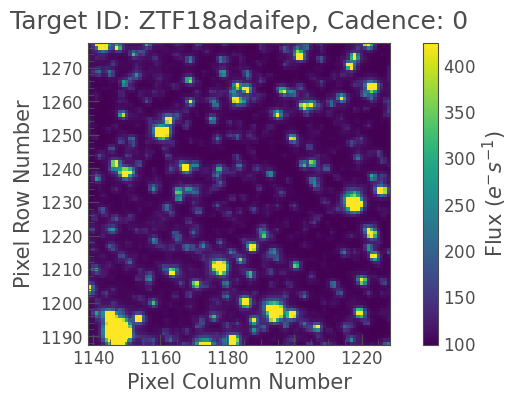

In [18]:
search_result = lk.search_tesscut('ZTF18adaifep')
tpf = search_result.download(cutout_size=90)
tpf.plot()

In [19]:
res = tr.Quick_reduce(tpf, calibrate=False)

made reference
made source mask
calculating background
background subtracted
calculating centroids


/home/tomas/anaconda3/lib/python3.6/site-packages/tessreduce/tessreduce.py:512: LightkurveDeprecationWarning: The astropy_time function is deprecated and may be removed in a future version.
        Use time instead.
  split = np.where(np.diff(tpf.astropy_time.mjd) > 0.5)[0][0] + 1


images shifted
made light curve


/home/tomas/anaconda3/lib/python3.6/site-packages/tessreduce/tessreduce.py:823: LightkurveDeprecationWarning: The astropy_time function is deprecated and may be removed in a future version.
        Use time instead.
  lc = Make_lc(tpf.astropy_time.mjd,flux,aperture=aper,bin_size=bin_size,


In [20]:
flux = res['flux']
med_frame = tr.Get_ref(flux)

In [21]:
tab = tr.Unified_catalog(tpf, magnitude_limit=18)

In [22]:
col = tab.col.values + 0.5
row = tab.row.values + 0.5
pos = np.array([col, row]).T
index, med_cut, stamps = tr.Isolated_stars(pos, tab['tmag'].values, flux, med_frame, Distance=5, Aperture=5)

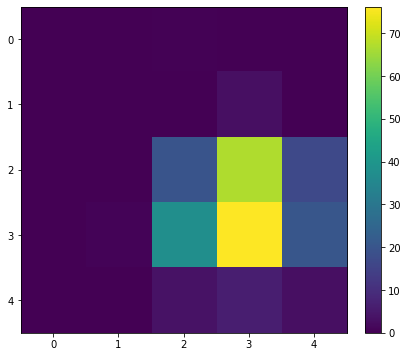

(13, 987, 5, 5)


In [23]:
fig, ax = plt.subplots(figsize=(8, 6))

plt.imshow(stamps[0][100], vmin=0)
plt.colorbar(fraction=0.046, pad=0.04)  
fig.patch.set_facecolor('xkcd:white')
plt.show()

print(stamps.shape)

___
## TESS light curve

In [24]:
def extract_tess_lc(oid, method='tpf', plot=True):
    """ Extracts a TESS lightcurve using a ZTF ID.

    Parameters
    ----------

    oid: str
    Target's ZTF ID.
    method: str, default 'tpf
    Method to extract the light curve. Either 'tpf' or 'cpm'
    plot, bool
    Wether or not to plot the extracted light curve

    Returns
    -------
    Target's data and TESS light curve.
    """

    target = get_ztf_target(oid)

    coords = target["coords"]
    ra, dec = coords.ra.value, coords.dec.value
    sector = target["sectors"][0]
    size = 90

    if method=='tpf':
        tpf = tr.Get_TESS(ra,dec,size,sector)
        reduce_output = tr.Quick_reduce(tpf,bin_size=12,all_output=True)

    if plot:
        if not subtract_host:
            tr.Plotter(reduce_output['lc'][0], reduce_output['lc'][1])

        else:
            ref = tr.Get_ref(reduce_output['flux'],stop=400)
            lc = tr.Make_lc(tpf.astropy_time.mjd,reduce_output['flux']-ref,bin_size=12)

        tr.Plotter(lc[0,:],lc[1,:])

    return reduce_output

___
## PRF fitting

In [25]:
import numpy as np
import george
import scipy
import emcee

In [26]:
def gp_2d_fit(image_data, kernel='matern32'):
    """Fits data in 2D with gaussian process.

    The package ``george`` is used for the gaussian process fit.

    Parameters
    ----------
    image_data : 2-D array
        An image of N x N dimensions.
    kernel : str, default ``matern32``
        Kernel to be used to fit the light curves with gaussian process. E.g., ``matern52``, ``matern32``, ``squaredexp``.
    use_mcmc: bool, default ``False``
        Whether or not to use MCMC in the optimization of the gaussian process hyperparameters.
    Returns
    -------
    Returns a gaussian-process interpolated copy of the input image.
    """

    # define the objective function (negative log-likelihood in this case)
    def neg_ln_like(p):
        gp.set_parameter_vector(p)
        return -gp.log_likelihood(y)

    # and the gradient of the objective function
    def grad_neg_ln_like(p):
        gp.set_parameter_vector(p)
        return -gp.grad_log_likelihood(y)

    # for mcmc
    def lnprob(p):
        gp.set_parameter_vector(p)
        return gp.log_likelihood(y, quiet=True) + gp.log_prior()

    # prevents from changing the original values
    image = np.copy(image_data)
    
    # extract x values and reshape them for compatibility with george
    N = image.shape[0]
    x1 = np.hstack([list(range(0, N)) for i in range(0, N)])
    x2 = np.hstack([i]*N for i in range(0, N))
    X = np.array([x1, x2]).reshape(2, -1).T
    
    y = np.hstack(image)
    # normalize data
    y_norm = y.max()
    y /= y_norm
    
    # define kernel
    kernels_dict = {'matern52':george.kernels.Matern52Kernel,
                    'matern32':george.kernels.Matern32Kernel,
                    'squaredexp':george.kernels.ExpSquaredKernel,
                    }
    assert kernel in kernels_dict.keys(), f'"{kernel}" is not a valid kernel, choose one of the following ones: {list(kernels_dict.keys())}'

    var = np.std(y)
    length = 1  # random value, it can have a smarter initial value

    ker1, ker2 = kernels_dict[kernel], kernels_dict[kernel]
    ker = var * ker1(length**2, ndim=2, axes=0) * ker2(length**2, ndim=2, axes=1)
    
    mean_function = image_data.min()
    gp = george.GP(kernel=ker, mean=mean_function, fit_mean=False)
    
    # initial guess
    gp.compute(X)
    print('GP initial guess computed')
    
    # optimization routine for hyperparameters
    p0 = gp.get_parameter_vector()
    results = scipy.optimize.minimize(neg_ln_like, p0, jac=grad_neg_ln_like, method="Nelder-Mead")  # Nelder-Mead, L-BFGS-B, Powell, etc
    gp.set_parameter_vector(results.x)

    # steps for the predicted x1 and x2 dimensions
    step = 0.05
    x1_min, x1_max = x1.min(), x1.max()
    x2_min, x2_max = x2.min(), x2.max()
    X_predict = np.array(np.meshgrid(np.arange(x1_min, x1_max+step, step),
                             np.arange(x2_min, x2_max+step, step))).reshape(2, -1).T
    
    y_pred, var_pred = gp.predict(y, X_predict, return_var=True)
    yerr_pred = np.sqrt(var_pred)
    print('values predicted')

    # de-normalize results
    y_pred *= y_norm
    
    # Let's reshape the GP output to display it as an image
    temp_array = np.arange(x1.min(), x1.max()+step, step)
    N_pred = temp_array.shape[0]
    image_pred = np.array([y_pred[i*N_pred:(i+1)*N_pred] for i in range(N_pred)])

    return image_pred

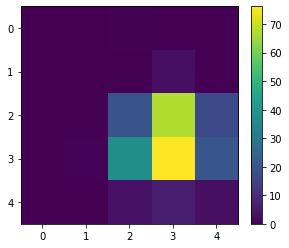

In [27]:
test_stamp = stamps[0][100]
test_stamp.shape

fig, ax = plt.subplots(figsize=(6, 4))

plt.imshow(test_stamp, vmin=0)
plt.colorbar(fraction=0.046, pad=0.04)  
fig.patch.set_facecolor('xkcd:white')
plt.show()

In [28]:
Y_pred = gp_2d_fit(test_stamp, kernel='matern32')

GP initial guess computed
values predicted


/home/tomas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


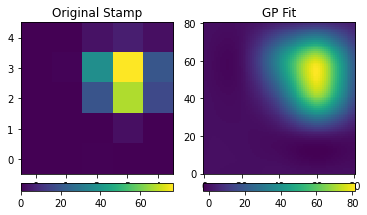

In [29]:
fig = plt.subplot(1, 2, 1)

plt.imshow(test_stamp, cmap='viridis', aspect=1, interpolation='nearest',  origin='lower')
plt.title('Original Stamp')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)

plt.subplot(1 ,2, 2)
plt.imshow(Y_pred, cmap='viridis', aspect=1, interpolation='nearest', origin='lower')
plt.title('GP Fit')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)
fig.patch.set_facecolor('xkcd:white')
plt.show()

In [42]:
pixel_dict = {}
N = Y_pred.shape[0]

step = 0.1
X_pred = np.array(np.meshgrid(np.arange(0, N+step, step),
                             np.arange(0, N+step, step))).reshape(2, -1).T

for i in range(0, N):
    pixel_ind = np.argmin(np.abs(i - X_pred.T[1]))
    pixel = X_pred.T[1][pixel_ind] 
    inds = [j for j, p1xp2_tuplet in enumerate(X_pred) if p1xp2_tuplet[1]==pixel]

    pixels, flux, err = X_pred.T[0][inds], Y_pred[inds], 0.0
    pixel_dict[i] = {'pixels':pixels, 'flux':flux, 'err':err}

IndexError: index 81 is out of bounds for axis 0 with size 81

In [40]:
# plot of columns (or rows?)

i = 2  # pixel column

#gp prediction
pixels, flux, err = pixel_dict[i]['pixels'], pixel_dict[i]['flux'], pixel_dict[i]['err']

# data
data_mask = np.where(i == X2)
data_x, data_y = X1[:Np], Y[data_mask]

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(pixels, flux)
ax.fill_between(pixels, flux-err, flux+err, alpha=0.2, color='g')
ax.plot(data_x, data_y)
fig.patch.set_facecolor('xkcd:white')

KeyError: 2

In [16]:
from astropy.utils.data import download_file

In [20]:
def sn_alias(name):
    url = 'https://api.astrocats.space/{}/alias'.format(name)
    if open(response).read(10) == '# Flag: -1':  # error code detected?
        raise IOError("No target found for {}".format(name) + open(response).read())
    res = pd.read_csv(response, delimiter='|', skiprows=2)
    return res

In [25]:
url = 'https://api.astrocats.space/{}/alias'.format('sn2020dbg')
response = download_file(url, cache=False)
if open(response).read(10) == '# Flag: -1':  # error code detected?
    raise IOError("No target found for {}".format(name) + open(response).read())
res = pd.read_csv(response, delimiter='|', skiprows=2)

EmptyDataError: No columns to parse from file

In [36]:
response.content

b'{"message": "Event \'snss2020dbg\' not found in any catalog."}\n'

In [102]:
import requests
import json
def alias(name,catalog='ztf'):
    url = 'https://api.astrocats.space/{}/alias'.format(name)
    response = requests.get(url)
    json_acceptable_string = response.content.decode("utf-8").replace("'", "").split('\n')[0]
    d = json.loads(json_acceptable_string)
    try:
        print(d['message'])
        return 'none'
    except:
        pass
    alias = d[name]['alias']
    names = [x['value'] for x in alias]
    names = np.array(names)
    ind = [x.lower().startswith(catalog) for x in names]
    return names[ind][0]

In [105]:
name = 'sn2020dbg'
alias(name)

'ZTF20aapycrh'

In [87]:
names.lower()

AttributeError: 'list' object has no attribute 'lower'

In [74]:
d['alias']

KeyError: 'alias'

In [41]:
type(response.content)

bytes

In [43]:
response.content.decode("utf-8") 

'{"message": "Event \'snss2020dbg\' not found in any catalog."}\n'

In [48]:
json_acceptable_string

'{"message": "Event "snss2020dbg" not found in any catalog."}'

In [88]:
'a'.startswith('a')

True

In [111]:
url = 'https://api.astrocats.space/catalog?ra=21.61932926&dec=62.1377889&closest'
response = requests.get(url)
json_acceptable_string = response.content.decode("utf-8").replace("'", "").split('\n')[0]
d = json.loads(json_acceptable_string)

In [113]:
d

{'message': 'No objects found within specified search region.'}